# Bajaj Finance

In [26]:
# Load necessary libraries
import sys
import warnings
warnings.filterwarnings('ignore')
import datetime
import gensim
import pandas as pd
import tqdm.notebook as tqdm
from tqdm.auto import tqdm
tqdm.pandas()

sys.path.append('/Users/pushkar/Documents/projects/fin_comp/comp/docs')

import utils.helper
from utils.helper import Processor
import importlib
importlib.reload(utils.helper)

import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 900
svg_renderer.height = 500
pio.renderers.default = "svg"
import plotly.express as px

In [2]:
# Load data
df = pd.read_csv('./../../data/nbfc/bajaj_finance/bajaj_finance.csv')

In [3]:
# Company username
company_username = 'Bajaj_Finance'

In [4]:
# Correct the format of variables
df['inReplyToTweetId'] = df['inReplyToTweetId'].apply(lambda x: '%.0f' % x).values.tolist()
df['conversation_id'] = df['conversation_id'].astype(str)

In [5]:
# Declare the query words
query_words = ['dm', 'customer experience', 'inconvenience', 'concern team', 'resolve', 
                'solve', 'no noc', 'await response', 'unpleasant experience']

In [6]:
# Declare the processor object
processor = Processor('./../../data/config.json')

In [7]:
# Check whether an observation is query for the company or not
df['is_query'] = 0

for word in tqdm(query_words):
    df['is_query'] = df['is_query'] + df['tweet'].apply(processor.word_distribution, find=word).astype(int)

  0%|          | 0/9 [00:00<?, ?it/s]

In [8]:
# Select observations of queries
qdf = df[(df['is_query']>0) & (df['username'] == company_username)]

In [9]:
qdf.shape

(22528, 28)

In [10]:
# Get all the conversation ids
conversation_ids = qdf['conversation_id'].unique()
print(f"Total number of unique conversations: {len(conversation_ids)}")

Total number of unique conversations: 17499


In [11]:
df['date'] = pd.to_datetime(df['date'])

## Response time

Response time is the time the company takes to respond to the first query.

In [12]:
result = pd.DataFrame()
result['conversation_id'] = conversation_ids
result['response_time'] = 0

In [14]:
for index, conversation_id in tqdm(enumerate(conversation_ids)):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    response_time = (comp_tmp.iloc[0]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
    result.at[index, 'response_time'] = response_time

0it [00:00, ?it/s]

In [15]:
result.head()

,conversation_id,response_time
0,1344317386132844545,0.000000
1,1343935142734123013,0.278611
2,1344311687264944128,0.000000
3,1344314012373188616,0.000000
4,1344286581432016896,1.002500


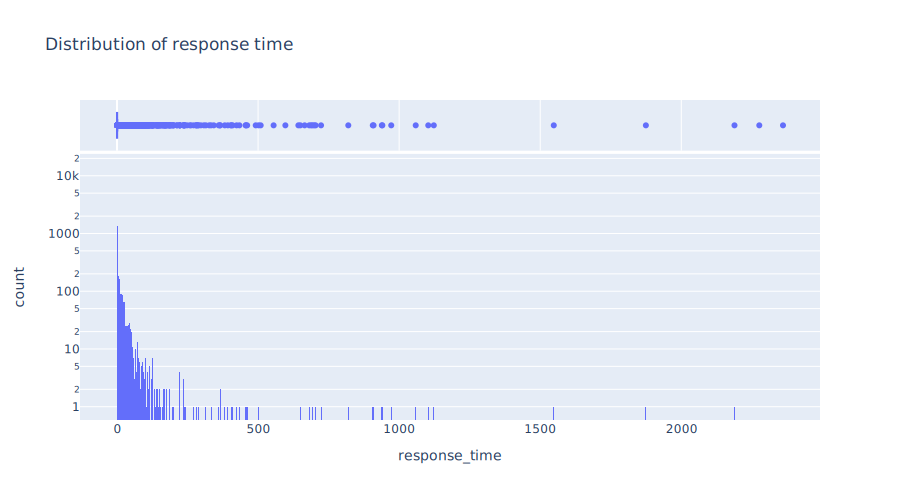

In [17]:
fig = px.histogram(result, x='response_time', log_y=True, marginal='box', title='Distribution of response time')
fig.show()

## Resolution time

Assuming that if the last query in the conversation is from the company then the issue is resolved.  
Resolution time is the time difference between the last date of last tweet in the conversation and the date of first query.

In [ ]:
result['resolution_time'] = 0

In [18]:
for index, conversation_id in tqdm(enumerate(conversation_ids)):
    tmp = df[df['conversation_id'] == conversation_id]
    tmp.sort_values('date', ascending=True, inplace=True)
    comp_tmp = tmp[tmp['username'] == company_username]
    if tmp.iloc[-1]['username'] == company_username:
        resolution_time = (tmp.iloc[-1]['date'] - tmp.iloc[0]['date']) / datetime.timedelta(hours=1)
        result.at[index, 'resolution_time'] = resolution_time

0it [00:00, ?it/s]

In [19]:
print(f"Number of queries resolved: {len(result['resolution_time'].to_numpy().nonzero()[0])}")
print(f"Number of queries unresolved: {result.shape[0] - len(result['resolution_time'].to_numpy().nonzero()[0])}")

Number of queries resolved: 12404
Number of queries unresolved: 5095


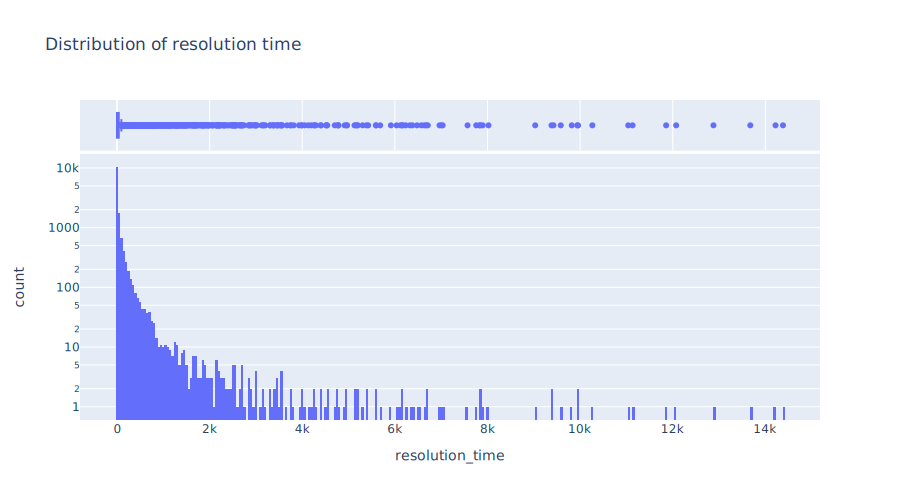

In [20]:
fig = px.histogram(result, x='resolution_time', log_y=True, marginal='box', title='Distribution of resolution time')
fig.show()

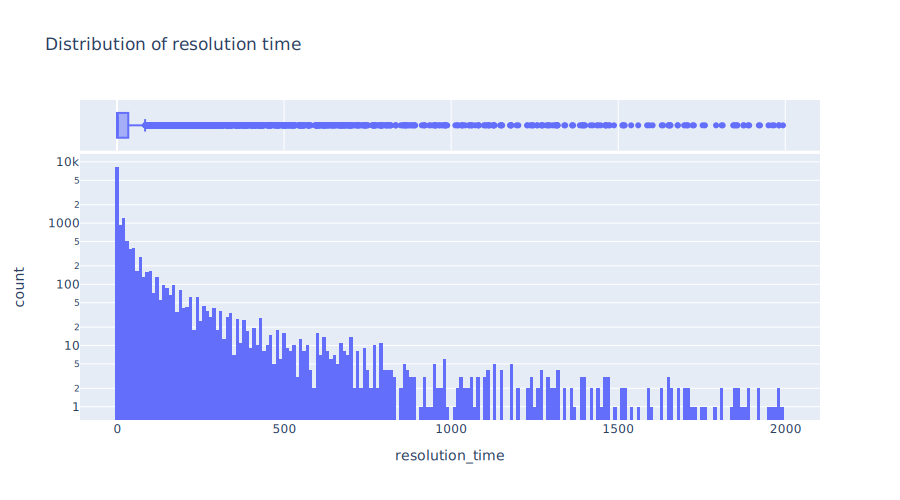

In [22]:
fig = px.histogram(result[result['resolution_time']<2000], x='resolution_time', log_y=True, marginal='box', title='Distribution of resolution time')
fig.show()

In [21]:
result.describe()

,response_time,resolution_time
count,17499.000000,14530.000000
mean,5.613538,107.529518
std,49.460617,570.374006
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,1.817778
75%,0.536944,37.756319
max,2360.426389,14380.907222


## Query Tweets Topics


In [38]:
queries = df[df['conversation_id'].isin(conversation_ids)]
queries.sort_values('date', ascending=True, inplace=True)
queries = queries[(queries['inReplyToTweetId'] == 'nan') & (queries['username'] != company_username)]
queries.shape


(5911, 28)

In [39]:
processor = Processor('./../../data/config.json')
pre_queries, post_queries = processor.preprocess(queries)
pre_id2word = gensim.corpora.Dictionary(pre_queries['bigram'].values.tolist())
post_id2word = gensim.corpora.Dictionary(post_queries['bigram'].values.tolist())
pre_corpus = [pre_id2word.doc2bow(text) for text in pre_queries['bigram'].values.tolist()]
post_corpus = [post_id2word.doc2bow(text) for text in post_queries['bigram'].values.tolist()]


In [40]:
pre_queries.shape


(2218, 31)

In [41]:
post_queries.shape


(3118, 31)

In [42]:
pre_lda_model = gensim.models.LdaMulticore(corpus=pre_corpus,
                                        id2word=pre_id2word,
                                        num_topics=4,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha=0.6,
                                        eta=0.3)
pre_coherence_model = gensim.models.CoherenceModel(model=pre_lda_model, 
                                                    texts=pre_queries['bigram'].values.tolist(), 
                                                    dictionary=pre_id2word, 
                                                    coherence='u_mass')
pre_coherence_model_score = pre_coherence_model.get_coherence()
print('Pre-COVID coherence Score: ', pre_coherence_model_score)

Pre-COVID coherence Score:  -3.510007564635065


In [43]:
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(pre_lda_model, pre_corpus, pre_id2word)
LDAvis_prepared


/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/en

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.146753  0.002786       1        1  29.723020
1     -0.023088 -0.118968       2        1  25.937661
3     -0.112607  0.018422       3        1  22.837583
0     -0.011059  0.097760       4        1  21.501735, topic_info=         Term        Freq       Total Category  logprob  loglift
30      calls  280.000000  280.000000  Default  30.0000  30.0000
311   calling  147.000000  147.000000  Default  29.0000  29.0000
144  emi_card   96.000000   96.000000  Default  28.0000  28.0000
104  deducted   61.000000   61.000000  Default  27.0000  27.0000
64    account  157.000000  157.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
37       need   24.924441   95.673262   Topic4  -5.5133   0.1919
27       time   25.279702  136.067665   Topic4  -5.4991  -0.1461
222  received   22.693254  107.317584   Topic4  -5.6071  -0.0167
48    service   22.521023  106.492462   Topic4  -5.6147  -0.0166
30      calls   24.622628  280.803081   Topic4  -5.5255  -0.8970

[308 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
125       1  0.025333         ac
125       2  0.050667         ac
125       3  0.253333         ac
125       4  0.684000         ac
64        1  0.038071    account
...     ...       ...        ...
1041      2  0.041808       year
1041      3  0.041808       year
1041      4  0.083616       year
1356      2  0.867832  yesterday
1356      4  0.072319  yesterday

[617 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])

In [44]:
pre_queries_topic_sents_keywords = processor.dominant_topics(ldamodel=pre_lda_model, 
                                                         corpus=pre_corpus, 
                                                         texts=pre_queries['bigram'].values.tolist(),
                                                         tweets=pre_queries['tweet'].values.tolist())


In [45]:
pre_queries_topic_sents_keywords['Topic_Keywords'].unique()


array(['loan, got, days, payment, today, response, times, card, help, customer_care',
       'loan, calls, calling, stop, people, guys, day, stop_calling, getting, loans',
       'emi, loan, account, deducted, customer_care, charges, month, customers, people, taken',
       'number, emi_card, account, card, loan, customer, emi, kindly, want, help'],
      dtype=object)

Following topics were discussed in Pre-COVID period:
1. Loan related queries
2. Unnecessary calls from the company
3. Issues with automatic EMI deductions
4. Issues with EMI card

In [53]:
# select = pre_queries_topic_sents_keywords['Topic_Keywords'].unique()[0]
# pre_queries_topic_sents_keywords[pre_queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



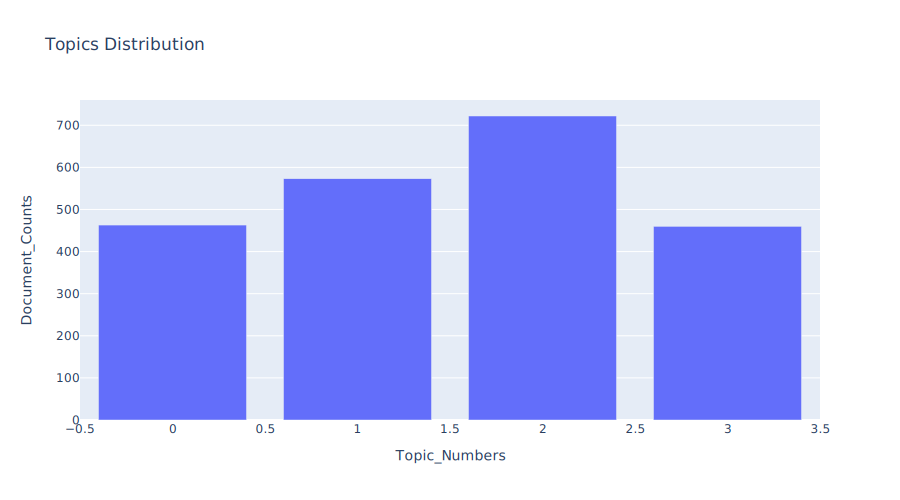

In [47]:
pre_queries_dist, fig = processor.plot_topic_distribution(pre_queries_topic_sents_keywords)
fig.show()


In [57]:
post_lda_model = gensim.models.LdaMulticore(corpus=post_corpus,
                                        id2word=post_id2word,
                                        num_topics=3,
                                        random_state=100,
                                        chunksize=100,
                                        passes=10,
                                        per_word_topics=True,
                                        alpha='symmetric',
                                        eta='symmetric')
post_coherence_model = gensim.models.CoherenceModel(model=post_lda_model, 
                                                    texts=post_queries['bigram'].values.tolist(), 
                                                    dictionary=post_id2word, 
                                                    coherence='u_mass')
post_coherence_model_score = post_coherence_model.get_coherence()
print('Post-COVID coherence Score: ', post_coherence_model_score)


Post-COVID coherence Score:  -2.9583063189910845


In [58]:
import pyLDAvis.gensim_models

import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(post_lda_model, post_corpus, post_id2word)
LDAvis_prepared


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.076963  0.091655       1        1  37.492634
0     -0.140906  0.005826       2        1  31.826195
2      0.063943 -0.097481       3        1  30.681171, topic_info=        Term        Freq       Total Category  logprob  loglift
54       emi  665.000000  665.000000  Default  30.0000  30.0000
1      calls  159.000000  159.000000  Default  29.0000  29.0000
21      paid  153.000000  153.000000  Default  28.0000  28.0000
209     dont  149.000000  149.000000  Default  27.0000  27.0000
117   paying   59.000000   59.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
40      want   40.481603  131.609796   Topic3  -5.7219   0.0025
130    money   41.050647  156.617366   Topic3  -5.7079  -0.1575
171     team   40.214900  206.988159   Topic3  -5.7285  -0.4569
189  finserv   38.538400  148.440763   Topic3  -5.7711  -0.1670
123     bank   38.312294  123.245585   Topic3  -5.7769   0.0131

[250 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2592      1  0.939313   accept
13        1  0.526376  account
13        2  0.228219  account
13        3  0.246624  account
92        1  0.972571  address
...     ...       ...      ...
160       2  0.232418       ur
160       3  0.474942       ur
40        1  0.273536     want
40        2  0.417902     want
40        3  0.303929     want

[376 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [59]:
post_queries_topic_sents_keywords = processor.dominant_topics(ldamodel=post_lda_model, 
                                                         corpus=post_corpus, 
                                                         texts=post_queries['bigram'].values.tolist(),
                                                         tweets=post_queries['tweet'].values.tolist())


In [60]:
post_queries_topic_sents_keywords['Topic_Keywords'].unique()

array(['loan, calls, number, dont, company, need, help, team, time, getting',
       'emi, loan, customer, paid, month, card, time, pay, account, moratorium',
       'emi, loan, account, moratorium, pay, card, payment, finserv, month, received'],
      dtype=object)

Following topics were discussed in the Post-COVID period:
1. Unnecessary calls from the company
2. EMI card and moratorium
3. Loan EMI and moratorium

In [64]:
# select = post_queries_topic_sents_keywords['Topic_Keywords'].unique()[2]
# post_queries_topic_sents_keywords[post_queries_topic_sents_keywords['Topic_Keywords'] == select]['Text'].values

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



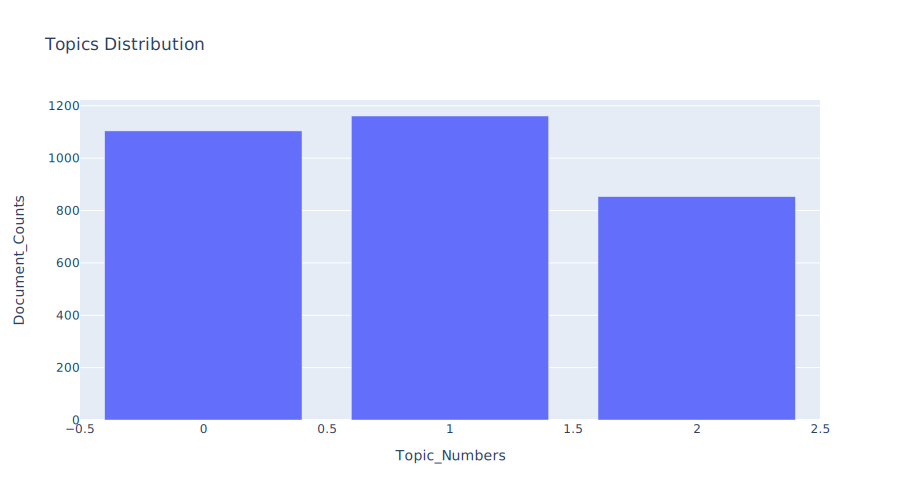

In [52]:
post_queries_dist, fig = processor.plot_topic_distribution(post_queries_topic_sents_keywords)
fig.show()